In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Tetris-v5
  logger.warn("Overriding environment {}".format(id))
c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Tetris-ram-v5
  logger.warn("Overriding environment {}".format(id))
c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Adventure-v5
  logger.warn("Overriding environment {}".format(id))
c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Adventure-ram-v5
  logger.warn("Overriding environment {}".format(id))
c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding enviro

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


In [3]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [4]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  # 价值网络
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)  # 价值网络优化器
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        # 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)  # 时序差分误差
        test = self.actor(states).gather(1, actions)
        log_probs = torch.log(self.actor(states).gather(1, actions)) #? 
        actor_loss = torch.mean(-log_probs * td_delta.detach())
        # 均方误差损失函数
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()  # 计算策略网络的梯度
        critic_loss.backward()  # 计算价值网络的梯度
        self.actor_optimizer.step()  # 更新策略网络的参数
        self.critic_optimizer.step()  # 更新价值网络的参数


In [5]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)


Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\37103\AppData\Local\Temp\ipykernel_24400\2516363337.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)


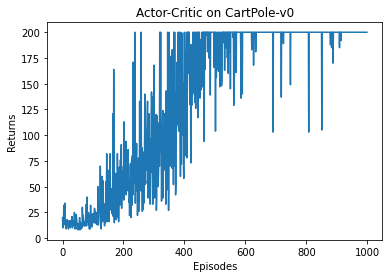

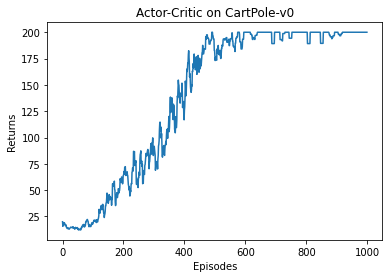

In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()


---

In [ ]:
import tensorflow as tf

logdir = 'logs/scalars'
file_writer = tf.summary.create_file_writer(logdir + "/AC_th")
file_writer.set_as_default()
with file_writer.as_default():
    for i in range(len(episodes_list)):
        tf.summary.scalar('return', return_list[i], episodes_list[i])

In [ ]:
file_writer.as_default()
for i in range(100000):
    tf.summary.scalar('123', data=10, step=i)

In [ ]:
s = torch.tensor([1, 2, 3])
s = s.view(-1, 1)
print(s)

tensor([[1],
        [2],
        [3]])


In [ ]:
t = torch.tensor([[1, 2], [3, 4]])
torch.gather(t, 1, torch.tensor([[0, 0], [1, 0]]))


tensor([[1, 1],
        [4, 3]])

In [ ]:
t = torch.tensor([[1, 2], [3, 4]])
torch.gather(t, 1, torch.tensor([[1, 1], [1, 0]]))


tensor([[2, 2],
        [4, 3]])

In [ ]:
t = torch.tensor([[1, 2], [3, 4]])
torch.gather(t, 0, torch.tensor([[0, 0], [1, 1]]))


tensor([[1, 2],
        [3, 4]])

In [ ]:
t = torch.tensor([[1, 2], [3, 4]])
torch.gather(t, 1, torch.tensor([[0, 0], [0, 0]]))


tensor([[1, 1],
        [3, 3]])

In [ ]:
actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
state = torch.tensor([env.reset()]).to(device)
state = torch.ones(10, state_dim).to(device)
print(state.shape)
a = actor(state)
print(a)

torch.Size([10, 4])
tensor([[0.5896, 0.4104],
        [0.5896, 0.4104],
        [0.5896, 0.4104],
        [0.5896, 0.4104],
        [0.5896, 0.4104],
        [0.5896, 0.4104],
        [0.5896, 0.4104],
        [0.5896, 0.4104],
        [0.5896, 0.4104],
        [0.5896, 0.4104]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


: 